In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Tumour")

In [3]:
!pwd

/content/drive/MyDrive/Tumour


In [4]:
!ls

README.dataset.txt  test  train  valid


In [5]:
data_dir = "/content/drive/MyDrive/Tumour"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import random
import json
import seaborn as sns
import pandas as pd

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.12,
    height_shift_range=0.12,
    zoom_range=0.18,
    brightness_range=(0.7, 1.3),
    shear_range=0.08,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    seed=SEED
)

Found 1695 images belonging to 4 classes.


In [10]:
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    seed=SEED,
    shuffle=False
)

Found 502 images belonging to 4 classes.


In [11]:
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    seed=SEED,
    shuffle=False
)


Found 246 images belonging to 4 classes.


In [12]:
num_classes = len(train_data.class_indices)
print("Number of classes:", num_classes)
print("class_indices:", train_data.class_indices)

Number of classes: 4
class_indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


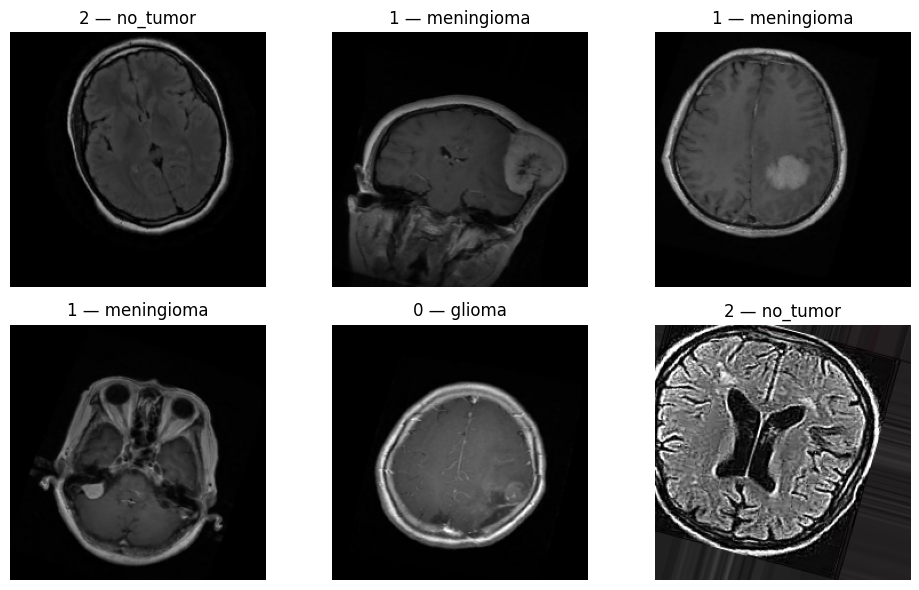

In [13]:
import matplotlib.pyplot as plt
class_labels = list(train_data.class_indices.keys())

plt.figure(figsize=(10,6))
for i in range(6):
    img, label = next(train_data)
    plt.subplot(2,3,i+1)
    plt.imshow(img[0])
    plt.title(f"{np.argmax(label[0])} — {class_labels[np.argmax(label[0])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_data.classes)
cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=train_data.classes)
class_weights = {int(k): float(v) for k, v in zip(classes, cw_vals)}
print("class_weights:", class_weights)

class_weights: {0: 0.7513297872340425, 1: 1.183659217877095, 2: 1.2649253731343284, 3: 0.9674657534246576}


In [15]:
import json

# Get class mapping from your training generator
class_indices = train_data.class_indices

# Invert dictionary to make index → class label
index_to_class = {v: k for k, v in class_indices.items()}

# Save to JSON file
with open("class_indices.json", "w") as f:
    json.dump(index_to_class, f, indent=4)

print("✅ Saved class_indices.json successfully!")
print(index_to_class)

✅ Saved class_indices.json successfully!
{0: 'glioma', 1: 'meningioma', 2: 'no_tumor', 3: 'pituitary'}


In [16]:
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3, EfficientNetB0

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,236,676 (50.49 MB)

 Trainable params: 13,235,716 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
# --- TRAIN CNN MODEL ---
early_cnn = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_cnn = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_cnn, reduce_cnn],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 742s 14s/step - accuracy: 0.4334 - loss: 12.8714 - val_accuracy: 0.1972 - val_loss: 18.7338 - learning_rate: 0.0010
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 534ms/step - accuracy: 0.4494 - loss: 1.5199 - val_accuracy: 0.1972 - val_loss: 13.6375 - learning_rate: 0.0010
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 534ms/step - accuracy: 0.5000 - loss: 1.2764 - val_accuracy: 0.1972 - val_loss: 22.4903 - learning_rate: 0.0010
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 535ms/step - accuracy: 0.5097 - loss: 1.2532 - val_accuracy: 0.1673 - val_loss: 8.1162 - learning_rate: 0.0010
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 520ms/step - accuracy: 0.5442 - loss: 1.1730 - val_accuracy: 0.1972 - val_loss: 10.2293 - learning_rate: 0.0010
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 516ms/step - accuracy: 0.5339 - loss: 1.1446 - val_accuracy: 0.1972 - val_loss: 5.6541 - learning_rate: 0.0010
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 516ms/step - accuracy: 0.5367 - loss

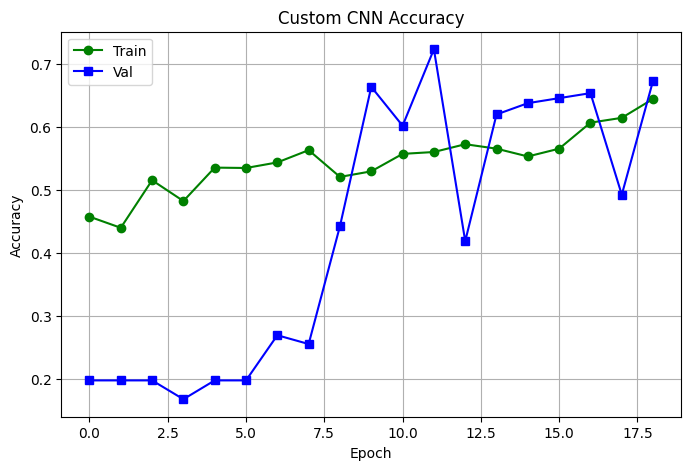

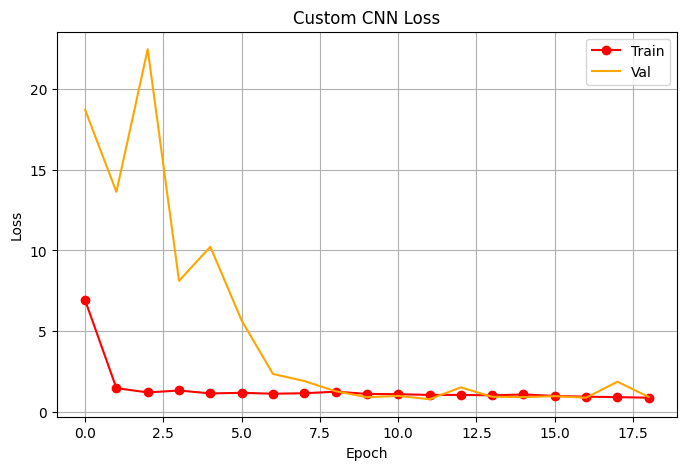

In [18]:
def plot_curves(hist, name):
    plt.figure(figsize=(8,5))
    plt.plot(hist.history['accuracy'],'g-o',label='Train')
    plt.plot(hist.history['val_accuracy'],'b-s',label='Val')
    plt.title(f'{name} Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(hist.history['loss'],'r-o',label='Train')
    plt.plot(hist.history['val_loss'],'orange',label='Val')
    plt.title(f'{name} Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.grid(True); plt.show()

plot_curves(history_cnn, "Custom CNN")

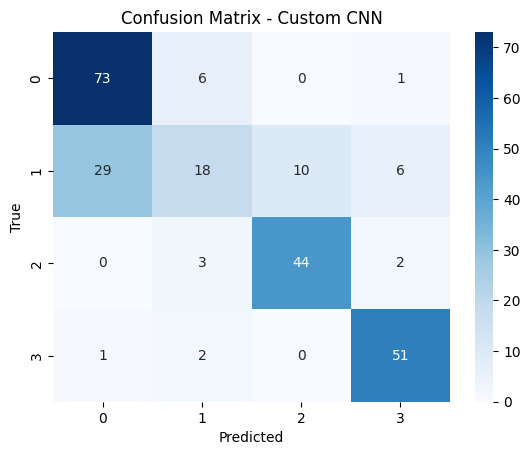

✅ CNN Evaluation Complete | Acc=0.7561, Prec=0.7486, Rec=0.7602, F1=0.7346


In [19]:
# --- EVALUATE CNN MODEL ---
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_data, verbose=0)
y_probs_cnn = cnn_model.predict(test_data, verbose=0)
y_pred_cnn = np.argmax(y_probs_cnn, axis=1)
y_true_cnn = test_data.classes

report_cnn = classification_report(y_true_cnn, y_pred_cnn, output_dict=True, zero_division=0)
prec_cnn = report_cnn['macro avg']['precision']
rec_cnn = report_cnn['macro avg']['recall']
f1_cnn = report_cnn['macro avg']['f1-score']

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Custom CNN'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

results = {}
results['CustomCNN'] = {
    'Accuracy': cnn_test_acc,
    'Loss': cnn_test_loss,
    'Precision': prec_cnn,
    'Recall': rec_cnn,
    'F1-Score': f1_cnn
}

print(f"✅ CNN Evaluation Complete | Acc={cnn_test_acc:.4f}, Prec={prec_cnn:.4f}, Rec={rec_cnn:.4f}, F1={f1_cnn:.4f}")

In [20]:
cnn_model.save("CustomCNN_base.keras")
print("✅ Custom CNN model saved as 'CustomCNN_base.keras'")

✅ Custom CNN model saved as 'CustomCNN_base.keras'


In [21]:
models_dict = {
    'ResNet50': ResNet50,
    'MobileNetV2': MobileNetV2,
    'InceptionV3': InceptionV3,
    'EfficientNetB0': EfficientNetB0
}


=== TRAINING ResNet50 ===

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.2376 - loss: 1.6397
Epoch 1: val_accuracy improved from -inf to 0.48406, saving model to ResNet50_base.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 867ms/step - accuracy: 0.2380 - loss: 1.6381 - val_accuracy: 0.4841 - val_loss: 1.3140 - learning_rate: 1.0000e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.2946 - loss: 1.4522
Epoch 2: val_accuracy did not improve from 0.48406
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 538ms/step - accuracy: 0.2947 - loss: 1.4518 - val_accuracy: 0.4821 - val_loss: 1.2571 - learning_rate: 1.0000e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.3518 - loss: 1.3267
Epoch 3: val_accuracy improved from 0.48406 to 0.58367, saving model to ResNet50_base.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 557ms/step - accuracy: 0.3514 - loss: 1.3269 - val_accuracy: 0.5837 - val_loss: 1.2371 - learning_rate: 1.00

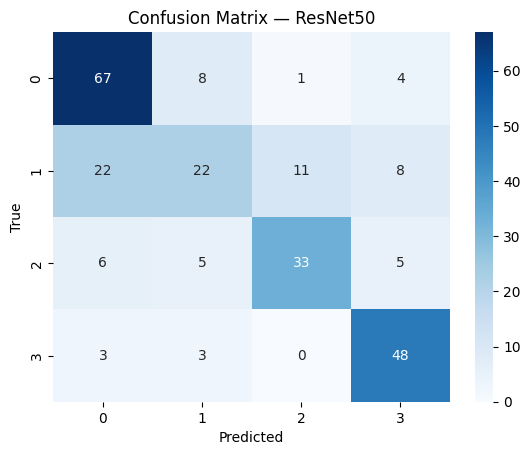

✅ ResNet50: Acc=0.6911, Prec=0.6836, Rec=0.6873, F1=0.6743

=== TRAINING MobileNetV2 ===

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.3673 - loss: 1.4848
Epoch 1: val_accuracy improved from -inf to 0.72510, saving model to MobileNetV2_base.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3697 - loss: 1.4792 - val_accuracy: 0.7251 - val_loss: 0.7099 - learning_rate: 1.0000e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.7029 - loss: 0.7961
Epoch 2: val_accuracy did not improve from 0.72510
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 514ms/step - accuracy: 0.7033 - loss: 0.7949 - val_accuracy: 0.7251 - val_loss: 0.6296 - learning_rate: 1.0000e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7666 - loss: 0.6136
Epoch 3: val_accuracy improved from 0.72510 to 0.80080, saving model to MobileNetV2_base.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 524ms/step - accuracy: 0.7669 - loss: 0.6131 

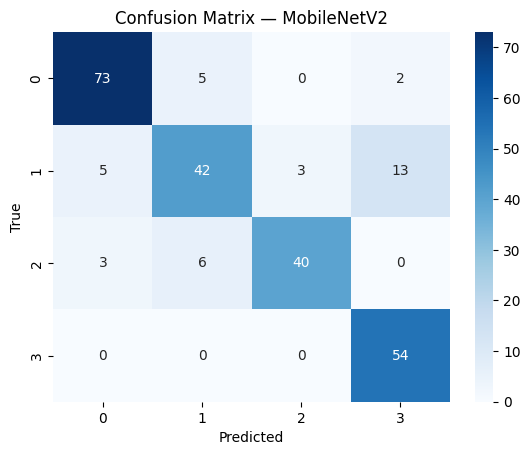

✅ MobileNetV2: Acc=0.8496, Prec=0.8516, Rec=0.8489, F1=0.8446

=== TRAINING InceptionV3 ===

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.4602 - loss: 1.2672
Epoch 1: val_accuracy improved from -inf to 0.75697, saving model to InceptionV3_base.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 66s 955ms/step - accuracy: 0.4615 - loss: 1.2643 - val_accuracy: 0.7570 - val_loss: 0.7085 - learning_rate: 1.0000e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7050 - loss: 0.7936
Epoch 2: val_accuracy improved from 0.75697 to 0.80677, saving model to InceptionV3_base.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 545ms/step - accuracy: 0.7055 - loss: 0.7925 - val_accuracy: 0.8068 - val_loss: 0.5885 - learning_rate: 1.0000e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.7463 - loss: 0.6440
Epoch 3: val_accuracy did not improve from 0.80677
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 539ms/step - accuracy: 0.7465 - loss:

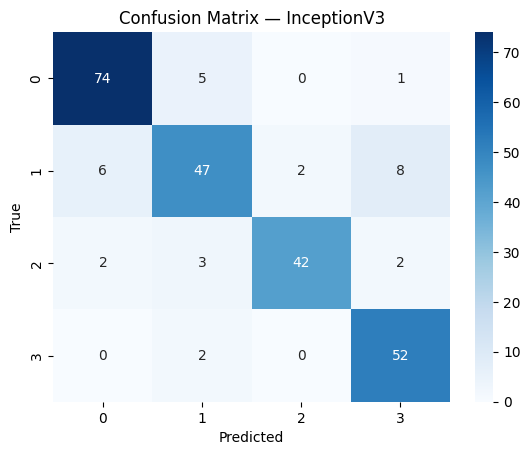

✅ InceptionV3: Acc=0.8740, Prec=0.8767, Rec=0.8728, F1=0.8723

=== TRAINING EfficientNetB0 ===

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.2273 - loss: 1.4148
Epoch 1: val_accuracy improved from -inf to 0.32072, saving model to EfficientNetB0_base.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.2275 - loss: 1.4147 - val_accuracy: 0.3207 - val_loss: 1.3750 - learning_rate: 1.0000e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.2255 - loss: 1.4212
Epoch 2: val_accuracy did not improve from 0.32072
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 529ms/step - accuracy: 0.2257 - loss: 1.4208 - val_accuracy: 0.3207 - val_loss: 1.3823 - learning_rate: 1.0000e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.2643 - loss: 1.3984
Epoch 3: val_accuracy did not improve from 0.32072
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 519ms/step - accuracy: 0.2642 - loss: 1.3983 - val_accuracy: 0.2351 - val_los

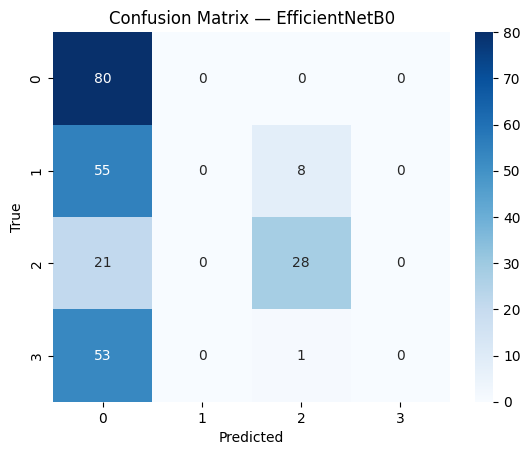

✅ EfficientNetB0: Acc=0.4390, Prec=0.2849, Rec=0.3929, F1=0.3012


In [22]:
for model_name, model_class in models_dict.items():
    tf.keras.backend.clear_session()
    print(f"\n=== TRAINING {model_name} ===\n")

    base = model_class(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base.trainable = False
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    base_ckpt = ModelCheckpoint(f"{model_name}_base.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
    early_base = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    reduce_base = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    history_base = model.fit(train_data, validation_data=val_data, epochs=20,
                             callbacks=[base_ckpt, early_base, reduce_base],
                             class_weight=class_weights)

    print(f"\n--- Fine-tuning {model_name} ---\n")
    model = tf.keras.models.load_model(f"{model_name}_base.keras")

    for layer in model.layers[-150:]:  # fixed 150 layers as agreed
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=Adam(learning_rate=1e-6), loss=loss_fn, metrics=['accuracy'])

    ft_ckpt = ModelCheckpoint(f"{model_name}_finetuned.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
    early_ft = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
    reduce_lr_ft = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    history_ft = model.fit(train_data, validation_data=val_data, epochs=10,
                           callbacks=[ft_ckpt, early_ft, reduce_lr_ft],
                           class_weight=class_weights)

    best_path = f"{model_name}_finetuned.keras" if os.path.exists(f"{model_name}_finetuned.keras") else f"{model_name}_base.keras"
    best_model = tf.keras.models.load_model(best_path)

    test_loss, test_acc = best_model.evaluate(test_data, verbose=0)
    y_probs = best_model.predict(test_data, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = test_data.classes

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    prec = report['macro avg']['precision']
    rec = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix — {model_name}')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

    results[model_name] = {'Accuracy': test_acc, 'Loss': test_loss, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}
    print(f"✅ {model_name}: Acc={test_acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

            Model  Accuracy (%)  Precision  Recall  F1-Score    Loss
0     InceptionV3         87.40     0.8767  0.8728    0.8723  0.6197
1     MobileNetV2         84.96     0.8516  0.8489    0.8446  0.6923
2       CustomCNN         75.61     0.7486  0.7602    0.7346  0.7305
3        ResNet50         69.11     0.6836  0.6873    0.6743  0.9093
4  EfficientNetB0         43.90     0.2849  0.3929    0.3012  1.3855


/tmp/ipython-input-721535859.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comp_df, x='Model', y='Accuracy (%)', palette='viridis')


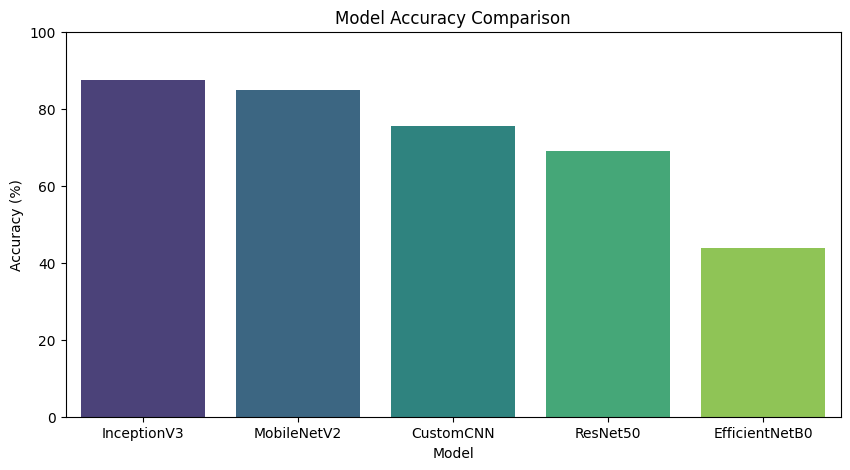

/tmp/ipython-input-721535859.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comp_df, x='Model', y='F1-Score', palette='mako')


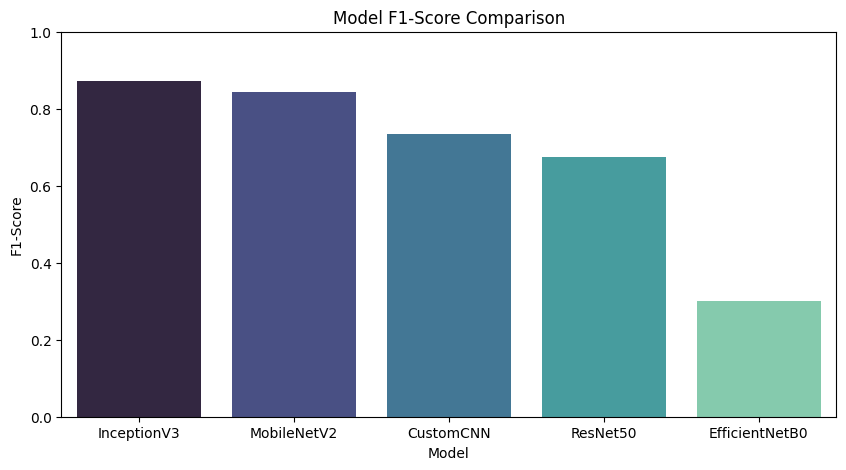

In [23]:
# --- FINAL PERFORMANCE COMPARISON ---
comp_df = pd.DataFrame([
    {"Model": name,
     "Accuracy (%)": round(info["Accuracy"]*100, 2),
     "Precision": round(info["Precision"], 4),
     "Recall": round(info["Recall"], 4),
     "F1-Score": round(info["F1-Score"], 4),
     "Loss": round(info["Loss"], 4)}
    for name, info in results.items()
])

comp_df = comp_df.sort_values(by="Accuracy (%)", ascending=False).reset_index(drop=True)
print(comp_df)

plt.figure(figsize=(10,5))
sns.barplot(data=comp_df, x='Model', y='Accuracy (%)', palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0,100)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=comp_df, x='Model', y='F1-Score', palette='mako')
plt.title('Model F1-Score Comparison')
plt.ylim(0,1)
plt.show()

In [24]:
comp_df.to_csv("final_model_comparison.csv", index=False)
print("📊 Results saved to final_model_comparison.csv")

📊 Results saved to final_model_comparison.csv


In [25]:
import shutil

# Identify best model by accuracy
best_row = comp_df.sort_values(by='Accuracy (%)', ascending=False).iloc[0]
best_model_name = best_row['Model']
best_accuracy = best_row['Accuracy (%)']

In [26]:
# Determine best model file (fine-tuned if available)
if os.path.exists(f"{best_model_name}_finetuned.keras"):
    best_model_path = f"{best_model_name}_finetuned.keras"
elif os.path.exists(f"{best_model_name}_base.keras"):
    best_model_path = f"{best_model_name}_base.keras"
else:
    best_model_path = f"{best_model_name}_best.keras"  # fallback for CNN or if naming differs

In [27]:
# Save unified model for deployment
final_model_path = "final_best_model.keras"
shutil.copy(best_model_path, final_model_path)

'final_best_model.keras'

In [28]:
# Save model name info
with open("best_model_name.txt", "w") as f:
    f.write(f"Best Model: {best_model_name}\nAccuracy: {best_accuracy}%\nFile: {final_model_path}")

print(f"🏆 Best model is **{best_model_name}** with Accuracy = {best_accuracy}%")
print(f"✅ Saved as {final_model_path} for deployment.")

🏆 Best model is **InceptionV3** with Accuracy = 87.4%
✅ Saved as final_best_model.keras for deployment.


In [34]:
model_final = load_model("final_best_model.keras")
print("✅ Final model loaded successfully!")

# Quick prediction test (first test image)
img_path = test_data.filepaths[1]
from tensorflow.keras.preprocessing import image

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model_final.predict(img_array)
pred_class = np.argmax(preds)
class_labels = list(test_data.class_indices.keys())

print(f"📸 Sample image: {img_path.split('/')[-1]}")
print(f"🧠 Predicted class: {class_labels[pred_class]} ({preds[0][pred_class]*100:.2f}%)")

✅ Final model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
📸 Sample image: Tr-gl_0018_jpg.rf.7a670766b8083a1b516a49e241a636bc.jpg
🧠 Predicted class: glioma (80.52%)


In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(test_data), axis=1)
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
[[74  5  0  1]
 [ 6 47  2  8]
 [ 2  3 42  2]
 [ 0  2  0 52]]


In [36]:
print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


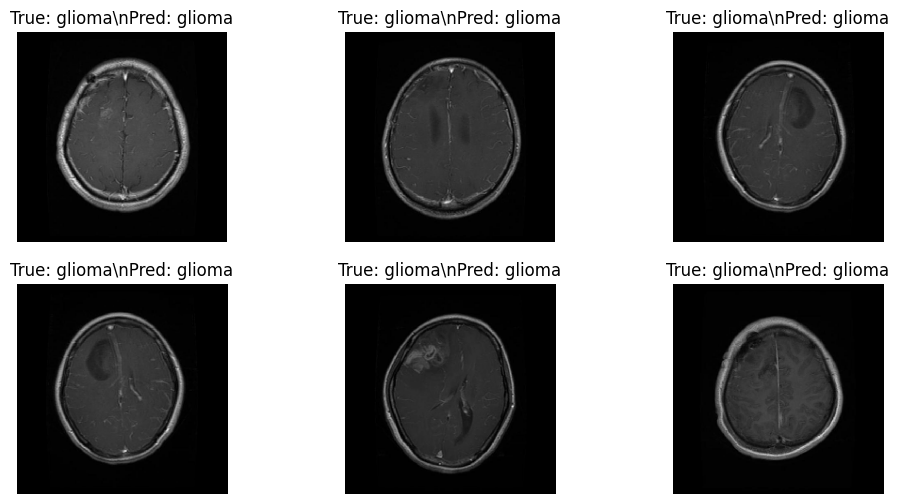

In [37]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

class_labels = list(train_data.class_indices.keys())

x_batch, y_batch = next(test_data)
preds = cnn_model.predict(x_batch)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_batch, axis=1)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(f"True: {class_labels[true_labels[i]]}\\nPred: {class_labels[pred_labels[i]]}")
    plt.axis('off')
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
MODEL_PATH = "final_best_model.keras"
model = load_model(MODEL_PATH)
print(f"✅ Loaded model: {MODEL_PATH}")

# ---------------------------------------------------------------
# ✅ STEP 2: Set dataset directories
# ---------------------------------------------------------------
BASE_DIR = "/content/drive/MyDrive/Tumour"

DATASETS = {
    "Train": os.path.join(BASE_DIR, "train"),
    "Validation": os.path.join(BASE_DIR, "valid"),
    "Test": os.path.join(BASE_DIR, "test")
}

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

# ---------------------------------------------------------------
# ✅ STEP 3: Evaluate on each dataset
# ---------------------------------------------------------------
for name, path in DATASETS.items():
    print(f"\n📊 Evaluating on {name} set...")

    gen = datagen.flow_from_directory(
        path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False
    )

    # Predict all samples
    preds = model.predict(gen, verbose=1)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = gen.classes
    labels = list(gen.class_indices.keys())

    # Compute metrics
    acc = accuracy_score(true_classes, pred_classes)
    total = len(true_classes)
    correct = np.sum(pred_classes == true_classes)
    incorrect = total - correct

    print(f"✅ {name} Accuracy: {acc*100:.2f}%")
    print(f"Total images: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Incorrect predictions: {incorrect}")

    # Classification Report
    print("\nDetailed Classification Report:")
    print(classification_report(true_classes, pred_classes, target_names=labels, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(true_classes, pred_classes)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    print("\nConfusion Matrix:")
    print(cm_df)

print("\n✅ Evaluation completed for all datasets.")

✅ Loaded model: final_best_model.keras

📊 Evaluating on Train set...
Found 1695 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step
✅ Train Accuracy: 94.69%
Total images: 1695
Correct predictions: 1605
Incorrect predictions: 90

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       564
  meningioma       0.89      0.89      0.89       358
    no_tumor       0.97      0.96      0.97       335
   pituitary       0.94      0.97      0.95       438

    accuracy                           0.95      1695
   macro avg       0.94      0.94      0.94      1695
weighted avg       0.95      0.95      0.95      1695


Confusion Matrix:
            glioma  meningioma  no_tumor  pituitary
glioma         540          23         0          1
meningioma      10         317         6         25
no_tumor         3           7       322          3
pituitary        0           9         3        426

📊 Evaluating on Validation set...
Found 502 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step
✅ Validation Accuracy: 89.84%
Total images: 502
Correct predictions: 451
Incorrect predictions: 51

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.95      0.94       161
  meningioma       0.86      0.77      0.81       124
    no_tumor       0.94      0.90      0.92        99
   pituitary       0.85      0.97      0.90       118

    accuracy                           0.90       502
   macro avg       0.90      0.90      0.89       502
weighted avg       0.90      0.90      0.90       502


Confusion Matrix:
            glioma  meningioma  no_tumor  pituitary
glioma         153           7         1          0
meningioma       9          95         5         15
no_tumor         0           5        89          5
pituitary        1           3         0        114

📊 Evaluating on Test set...
Found 246 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
✅ Test Accuracy: 87.40%
Total images: 246
Correct predictions: 215
Incorrect predictions: 31

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.90      0.93      0.91        80
  meningioma       0.82      0.75      0.78        63
    no_tumor       0.95      0.86      0.90        49
   pituitary       0.83      0.96      0.89        54

    accuracy                           0.87       246
   macro avg       0.88      0.87      0.87       246
weighted avg       0.88      0.87      0.87       246


Confusion Matrix:
            glioma  meningioma  no_tumor  pituitary
glioma          74           5         0          1
meningioma       6          47         2          8
no_tumor         2           3        42          2
pituitary        0           2         0         52

✅ Evaluation completed for all datasets.
